In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.regularizers as regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'  # 优化 GPU 线程分配
os.environ['TF_ENABLE_GPU_GARBAGE_COLLECTION'] = 'true'
# tf.config.threading.set_inter_op_parallelism_threads(16)
# 启用混合精度（FP16）
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)



2025-03-25 20:51:53.234192: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('stock_features.csv', parse_dates=True)
df['date'] = pd.to_datetime(df['date'])
target ='close'
features = df.drop(columns=['date', target]).values
X = features.copy()
y = df[target].copy().values.reshape(-1, 1)

In [3]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X)
y_train_scaled = scaler_y.fit_transform(y)


def create_sequeneces(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs).astype('float32'), np.array(ys).astype('float32')


In [4]:
"""数据增强"""
def moving_average_smoothing(series, window_size=3):
    smoothed_data = np.empty_like(series)  # 创建一个与原始数据形状相同的空数组
    for col in range(series.shape[1]):
        # 对每一列(每个特征)进行平滑处理
        smoothed_data[:,col] = np.convolve(series[:,col], np.ones(window_size)/window_size, mode='same')
    return smoothed_data

def random_noise(data, noise_factor=0.01):
    """随机噪声"""
    noise = noise_factor + np.random.randn(*data.shape)
    return data + noise

def time_series_shift(series, shift_range=5):
    """时间序列平移"""
    shift = np.random.randint(1, shift_range + 1)
    return np.concatenate([series[shift:], series[-shift:]], axis=0)

def data_augmentation(X, y, num_augmentations=5):
    augmented_X, augmented_y = [], []
    original_shape = X[0].shape  # 原始样本形状 (time_steps, features)
    for i in range(len(X)):
        # 移动平均平滑
        augmented_X.append(X[i])
        augmented_y.append(y[i])
        for _ in range(num_augmentations):
            # 增强方法1 平滑处理
            X_smooth = moving_average_smoothing(X[i])
            # 增加方法2 添加噪声
            X_noise = random_noise(X_smooth)
            # 增加方法3 时间偏移
            X_shift = time_series_shift(X_noise)
            # 断言增强后的形状一致
            assert X_shift.shape == original_shape, f"Shape mismatch: {X_shift.shape} vs {original_shape}"
            augmented_X.append(X_shift)
            augmented_y.append(y[i])
    return np.array(augmented_X), np.array(augmented_y)

In [5]:
def plot_history(history, fold =1):
    plt.figure(figsize=(16, 6))
    plt.plot(history.history['loss'], label=f'Fold {fold + 1} - Training Loss', color='blue', linewidth=2)
    # 绘制验证损失曲线（如果有验证集）
    plt.plot(history.history['val_loss'], label=f'Fold {fold + 1} - Validation Loss', color='orange', linewidth=2)

    plt.title(f'Fold {fold + 1} -Model Training History')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

In [6]:
def create_dataset(X, y, batch_size=128, shuffle=True):
    # 创建 TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.cache()  # 缓存到内存
    # 优化流水线（顺序很重要！）
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X)*2, reshuffle_each_iteration=True)
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda x, y: (x, y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)  # 自动预加载
    
    return dataset

Window Size: 30
划分数据集...
Origin traning data shape: (128956, 30, 39)
交叉验证...
Fold 1:
构建LSTM模型...


/opt/anaconda3/envs/python312/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 50)         │        18,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,705 (264.47 KB)

 Trainable params: 67,705 (264.47 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
4026/4026 ━━━━━━━━━━━━━━━━━━━━ 242s 59ms/step - loss: 0.2190 - mae: 0.1606 - val_loss: 0.0557 - val_mae: 0.2251
Epoch 2/20
4026/4026 ━━━━━━━━━━━━━━━━━━━━ 236s 59ms/step - loss: 0.0357 - mae: 0.1279 - val_loss: 0.0648 - val_mae: 0.2477
Epoch 3/20
4026/4026 ━━━━━━━━━━━━━━━━━━━━ 227s 56ms/step - loss: 0.0318 - mae: 0.1205 - val_loss: 0.0703 - val_mae: 0.2598
Epoch 4/20
4026/4026 ━━━━━━━━━━━━━━━━━━━━ 180s 45ms/step - loss: 0.0304 - mae: 0.1180 - val_loss: 0.0712 - val_mae: 0.2616
Epoch 5/20
4026/4026 ━━━━━━━━━━━━━━━━━━━━ 178s 44ms/step - loss: 0.0301 - mae: 0.1175 - val_loss: 0.0613 - val_mae: 0.2427
Epoch 6/20
4026/4026 ━━━━━━━━━━━━━━━━━━━━ 175s 43ms/step - loss: 0.0297 - mae: 0.1160 - val_loss: 0.0458 - val_mae: 0.2086
Epoch 7/20
4026/4026 ━━━━━━━━━━━━━━━━━━━━ 177s 44ms/step - loss: 0.0289 - mae: 0.1143 - val_loss: 0.0549 - val_mae: 0.2295
Epoch 8/20
4026/4026 ━━━━━━━━━━━━━━━━━━━━ 178s 44ms/step - loss: 0.0288 - mae: 0.1141 - val_loss: 0.0591 - val_mae: 0.2387
Epoch 9/20
4026/

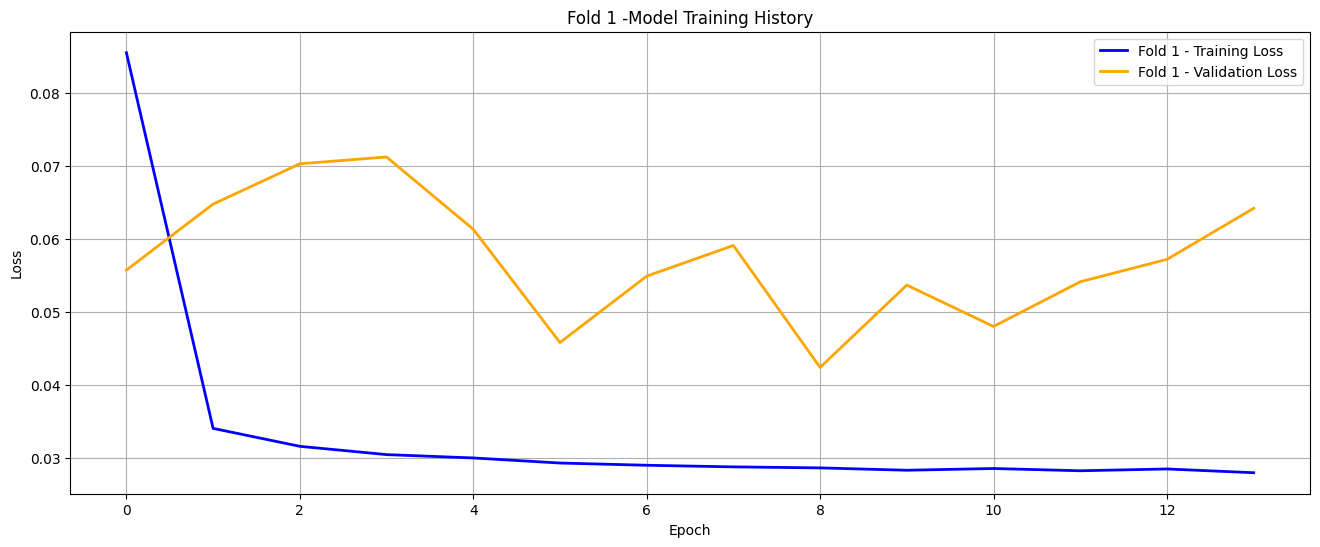

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step


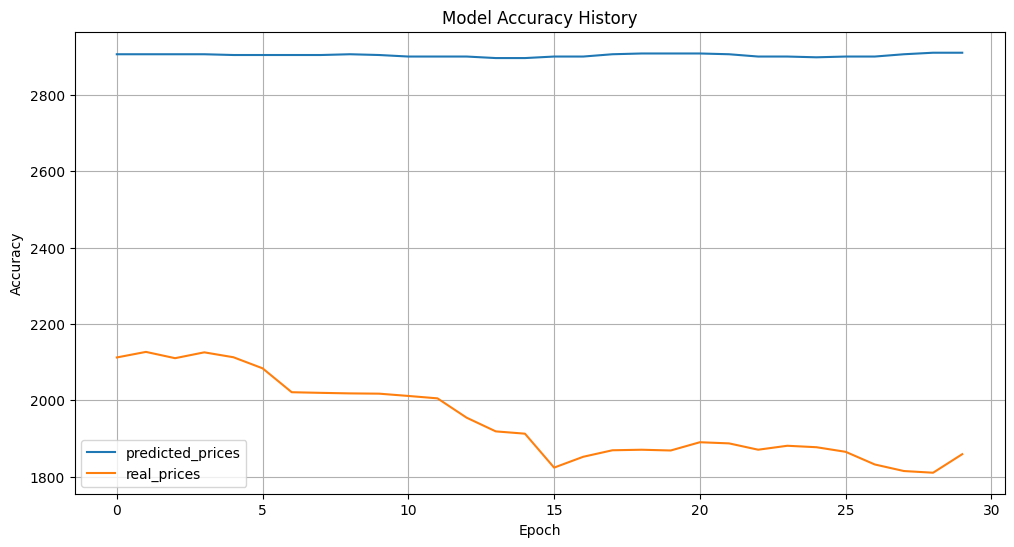

Fold 1 for window_30 - MSE: 924761.75, RMSE: 961.6453348298426, MAE: 956.0803833007812, R2: -85.01040649414062
Fold 2:
构建LSTM模型...


/opt/anaconda3/envs/python312/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 30, 50)         │        18,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,705 (264.47 KB)

 Trainable params: 67,705 (264.47 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
4027/4027 ━━━━━━━━━━━━━━━━━━━━ 273s 66ms/step - loss: 0.2191 - mae: 0.1623 - val_loss: 0.0862 - val_mae: 0.2862
Epoch 2/20
4027/4027 ━━━━━━━━━━━━━━━━━━━━ 243s 60ms/step - loss: 0.0353 - mae: 0.1277 - val_loss: 0.0768 - val_mae: 0.2715
Epoch 3/20
4027/4027 ━━━━━━━━━━━━━━━━━━━━ 231s 57ms/step - loss: 0.0322 - mae: 0.1214 - val_loss: 0.0429 - val_mae: 0.2009
Epoch 4/20
4027/4027 ━━━━━━━━━━━━━━━━━━━━ 257s 64ms/step - loss: 0.0310 - mae: 0.1194 - val_loss: 0.0424 - val_mae: 0.2001
Epoch 5/20
4027/4027 ━━━━━━━━━━━━━━━━━━━━ 215s 53ms/step - loss: 0.0305 - mae: 0.1184 - val_loss: 0.0383 - val_mae: 0.1907
Epoch 6/20
4027/4027 ━━━━━━━━━━━━━━━━━━━━ 198s 49ms/step - loss: 0.0295 - mae: 0.1159 - val_loss: 0.0410 - val_mae: 0.1973
Epoch 7/20
4027/4027 ━━━━━━━━━━━━━━━━━━━━ 283s 70ms/step - loss: 0.0289 - mae: 0.1145 - val_loss: 0.0503 - val_mae: 0.2199
Epoch 8/20
4027/4027 ━━━━━━━━━━━━━━━━━━━━ 256s 63ms/step - loss: 0.0294 - mae: 0.1158 - val_loss: 0.0403 - val_mae: 0.1951
Epoch 9/20
4027/

KeyboardInterrupt: 

In [7]:
window_sizes = [30]
metrics = ['MSE', 'RMSE', 'MAE', 'R2']

results = {window_size: {metric: [] for metric in metrics} for window_size in window_sizes}

def train_windows(X, y, window_size=24, stride=1):
    """
    将时间序列数据划分为多个窗口，每个窗口包含过去window_size个时间步的数据和下一个时间步的标签。
    """
    X_train, y_train = create_sequeneces(X, y, window_size)
    print("划分数据集...")

    # X_train_full_augmented, y_train_full_augmented = data_augmentation(X_train, y_train, num_augmentations=1)

    print(f"Origin traning data shape: {X_train.shape}")
    # print(f"Augmented traning data shape: {X_train_full_augmented.shape}")

    print("交叉验证...")
    tscv = TimeSeriesSplit(n_splits=5, test_size=30)
    result = {metric: [] for metric in metrics}
    for fold,(train_index, val_index) in enumerate(tscv.split(X_train)):
        print(f"Fold {fold + 1}:")
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        # X_train_fold_augmented, y_train_fold_augmented = data_augmentation(X_train_fold, y_train_fold)
        X_train_full_augmented, y_train_full_augmented = data_augmentation(X_train_fold, y_train_fold, num_augmentations=1)
        
        X_train_fold = X_train_full_augmented[train_index]
        # y_train_fold, y_val_fold = y_train_full_augmented[train_index], y_train_full_augmented[val_index]

        print("构建LSTM模型...")
        model = Sequential([
            LSTM(units=50, 
                input_shape=(X_train_fold.shape[1], X_train_fold.shape[2]),
                return_sequences=True,
                kernel_regularizer=regularizers.l2(0.01)),
            Dropout(0.3),
            LSTM(units=50, 
                return_sequences=True,
                kernel_regularizer=regularizers.l2(0.01)),
            Dropout(0.3),
            LSTM(units=64, return_sequences=False),
            Dropout(0.3),
            Dense(units=1)])

        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
        optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
        model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
        
        model.summary()
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        tf.debugging.set_log_device_placement(True)  # 打印设备分配日志
        # 替换原有数据集创建代码
        # 改进后（使用 prefetch 和并行化）
        train_dataset = create_dataset(X_train_fold, y_train_fold, batch_size=32)
        val_dataset = create_dataset(X_val_fold, y_val_fold, batch_size=32, shuffle=False)
        history = model.fit(train_dataset, epochs=20, validation_data=val_dataset, verbose=1,
                             callbacks=[early_stopping])

        # history = model.fit(X_train_fold, y_train_fold, epochs=20, batch_size=32, validation_data=(X_train_fold, y_train_fold), verbose=1,
        #                      callbacks=[early_stopping])
        plot_history(history=history, fold=fold)

        val_predictions = model.predict(X_val_fold)
        val_predictions_prices = scaler_y.inverse_transform(val_predictions)
        val_real_prices = scaler_y.inverse_transform(y_val_fold.reshape(-1, 1))


        plt.figure(figsize=(12, 6))
        plt.plot(val_predictions_prices[-100:], label='predicted_prices')
        plt.plot(val_real_prices[-100:], label='real_prices')
        plt.title('Model Accuracy History')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend()
        plt.grid(True)
        plt.show()
        mse = mean_squared_error(val_real_prices, val_predictions_prices)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(val_real_prices, val_predictions_prices)
        r2 = r2_score(val_real_prices, val_predictions_prices)
        result['MSE'].append(mse)
        result['RMSE'].append(rmse)
        result['MAE'].append(mae)
        result['R2'].append(r2)
        print(f"Fold {fold + 1} for window_{window_size} - MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R2: {r2}")
    return result

for window_size in window_sizes:
    print(f"Window Size: {window_size}")
    result = train_windows(X_train_scaled, y_train_scaled, window_size=window_size)
    results[window_size] = result

averages = {window_size: {metric: np.mean(result[metric]) for metric in result} for window_size, result in results.items()}

# 对指标进行对数变换，仅对MSE、RMSE进行操作
log_transformed_averages = {window_size: {
    "MSE": np.log(averages[window_size]["MSE"]),
    "RMSE": np.log(averages[window_size]["RMSE"]),
    "MAE": averages[window_size]["MAE"],
    "R2": averages[window_size]["R2"] 
    } for window_size in results.items()}

colors = sns.color_palette("Blues", len(window_sizes))
r = np.arange(len(metrics))
plt.figure(figsize=(10, 6))
barWidth = 0.15 # 每个柱子的宽度
for i, (window_size, result) in enumerate(results.items()):
    avg_metrics =[log_transformed_averages[metric] for metric in metrics]
    bars = plt.bar(r + i * barWidth, avg_metrics, width=barWidth, color=colors[i], edgecolor='white', label=f'Window Size {window_size}')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')
plt.xlabel("Metrics", fontweight='bold')
plt.ylabel("log-transformed / Original Value", fontweight='bold')
plt.xticks([r + barWidth * (len(window_sizes) /2 -0.5) for r in np.arange(len(metrics))], metrics)

plt.title("Log-Transformed Evaluation Metrics for Different Window Sizes", fontweight='bold')

plt.legend()
plt.tight_layout()
plt.show()


